In [1]:
import numpy as np

## 1. Criando o dataset

In [2]:
from PIL import Image
from os import listdir
from os.path import isdir

In [3]:
# Definindo uma função que retornará uma lista com as imagens em formato array e uma lista com os labels de cada imagem

def create_dataset(diretorio): 

    imagens = list() 
    labels = list()  

    for subdir in listdir(diretorio): 

        path_1 = diretorio + "/" + subdir + "/"

        for filename in listdir(path_1):

            path_2 = path_1 + filename
            image = Image.open(path_2)
            image = image.convert("RGB")
            image = image.resize((150, 150))
            image_array = np.asarray(image)

            imagens.append(image_array)
            labels.append(subdir)

    return imagens, labels

In [4]:
name_dir = "/home/isabella/Documents/projects/grapevine_disesase/dataset"

imagens_inicial, labels_inicial = create_dataset(name_dir)

## 2. Visualizando uma imagem do dataset

In [5]:
# Cada imagem foi armazenada com um array do numpy

print(imagens_inicial[0])
print(type(imagens_inicial[0]))

[[[198 188 187]
  [202 192 191]
  [201 191 190]
  ...
  [187 175 175]
  [189 177 177]
  [180 168 168]]

 [[200 190 189]
  [201 191 190]
  [200 190 189]
  ...
  [192 180 180]
  [190 178 178]
  [189 177 177]]

 [[198 188 187]
  [198 188 187]
  [196 186 185]
  ...
  [191 179 179]
  [194 182 182]
  [190 178 178]]

 ...

 [[201 190 186]
  [198 187 183]
  [199 188 184]
  ...
  [179 165 162]
  [180 166 163]
  [181 167 164]]

 [[200 189 185]
  [197 186 182]
  [198 187 183]
  ...
  [176 162 159]
  [173 159 156]
  [178 164 161]]

 [[198 187 183]
  [195 184 180]
  [196 185 181]
  ...
  [178 164 161]
  [177 163 160]
  [173 159 156]]]
<class 'numpy.ndarray'>


* Primeira possibilidade: visualizar usando a biblioteca PIL

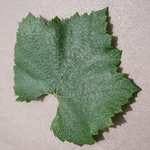

In [6]:
Image.fromarray(imagens_inicial[0])

* Segunda possibilidade: visualizar usando a biblioteca matplotlib.pyplot

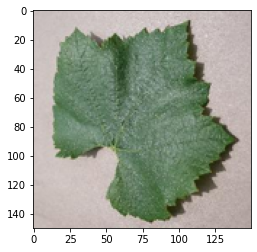

In [7]:
import matplotlib.pyplot as plt

plt.imshow(imagens_inicial[0])
plt.show()

## 3. Formatando os dados para a rede neural

In [8]:
imagens = np.array(imagens_inicial) / 255.0
# O array que representa uma imagem está variando, agora, de 0-1
imagens[0]

array([[[0.77647059, 0.7372549 , 0.73333333],
        [0.79215686, 0.75294118, 0.74901961],
        [0.78823529, 0.74901961, 0.74509804],
        ...,
        [0.73333333, 0.68627451, 0.68627451],
        [0.74117647, 0.69411765, 0.69411765],
        [0.70588235, 0.65882353, 0.65882353]],

       [[0.78431373, 0.74509804, 0.74117647],
        [0.78823529, 0.74901961, 0.74509804],
        [0.78431373, 0.74509804, 0.74117647],
        ...,
        [0.75294118, 0.70588235, 0.70588235],
        [0.74509804, 0.69803922, 0.69803922],
        [0.74117647, 0.69411765, 0.69411765]],

       [[0.77647059, 0.7372549 , 0.73333333],
        [0.77647059, 0.7372549 , 0.73333333],
        [0.76862745, 0.72941176, 0.7254902 ],
        ...,
        [0.74901961, 0.70196078, 0.70196078],
        [0.76078431, 0.71372549, 0.71372549],
        [0.74509804, 0.69803922, 0.69803922]],

       ...,

       [[0.78823529, 0.74509804, 0.72941176],
        [0.77647059, 0.73333333, 0.71764706],
        [0.78039216, 0

In [9]:
# Os labels serão transformados em: folhas saudáveis - [0,1] | folhas doentes - [1,0]

from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

labels = np.array(labels_inicial)
binarize = LabelBinarizer()
labels = binarize.fit_transform(labels)
labels = to_categorical(labels)

labels_inicial[0], labels[0]

('grape_healthy', array([0., 1.], dtype=float32))

## 4. Definindo alguns hiperparâmetros

In [10]:
batch_size = 300
input_shape = (150, 150, 3)
random_state = 42
learning_rate = 1e-5
epochs = 10

## 5. Definindo os Callbacks

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

* Primeiro callback será o Model Checkpoint, para salvar sempre o melhor modelo obtido durante a fase de treinamento

In [12]:
filepath = "model_callback.hdf5" # nome do arquivo que será salvo
checkpoint = ModelCheckpoint(filepath, monitor = "auc", verbose = 1, save_best_only = True, mode = "max")

* Segundo callback será o Reduce Plateau, para 

In [13]:
lr_reduce = ReduceLROnPlateau(monitor = "auc", factor = 0.1, min_delta = 0.0001, patience = 5, verbose = 1)

* Colocando os dois callbacks em uma lista que será apresentada ao modelo

In [14]:
callbacks = [checkpoint, lr_reduce]

## 6. Dividino os dados em treinamento e teste

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
Xtrain, Xtest, ytrain, ytest = train_test_split(imagens, labels, test_size=0.2, stratify=labels, random_state=random_state, shuffle=True)

In [17]:
Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((1282, 150, 150, 3), (321, 150, 150, 3), (1282, 2), (321, 2))

## 7. Importando e configurando o modelo base: VGG19

In [18]:
from tensorflow.keras.applications import VGG19

In [19]:
# Note que já estou usando os pesos da VGG19 sem as 3 últimas camadas (top)

VGG19_base = VGG19(weights = "/home/isabella/Documents/projects/grapevine_disesase/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5", 
                   include_top = False, 
                   input_shape = input_shape)

VGG19_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [20]:
# Somente as camadas do "block_5" serão treinadas
# Os pesos das outras camadas serão utilizados conforme já treinados pela VGG19 originalmente

VGG19_base.trainable = True
for layer in VGG19_base.layers:
    if layer.name[0:6] != "block5":
        layer.trainable = False
    print(layer.name, "Trainable? ",layer.trainable)

input_1 Trainable?  False
block1_conv1 Trainable?  False
block1_conv2 Trainable?  False
block1_pool Trainable?  False
block2_conv1 Trainable?  False
block2_conv2 Trainable?  False
block2_pool Trainable?  False
block3_conv1 Trainable?  False
block3_conv2 Trainable?  False
block3_conv3 Trainable?  False
block3_conv4 Trainable?  False
block3_pool Trainable?  False
block4_conv1 Trainable?  False
block4_conv2 Trainable?  False
block4_conv3 Trainable?  False
block4_conv4 Trainable?  False
block4_pool Trainable?  False
block5_conv1 Trainable?  True
block5_conv2 Trainable?  True
block5_conv3 Trainable?  True
block5_conv4 Trainable?  True
block5_pool Trainable?  True


In [21]:
VGG19_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## 8. Criando o modelo final

In [22]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.metrics import AUC

In [23]:
model = models.Sequential()

model.add(VGG19_base)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(0.8))
model.add(layers.Dense(2, activation="softmax"))

In [24]:
model.compile(loss="categorical_crossentropy", 
              optimizer="adam",
              metrics=[AUC()])

## 9. Treinando o modelo

In [25]:
history = model.fit(Xtrain, 
                    ytrain,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=(Xtest, ytest))

Epoch 1/10
5/5 [==============================] - ETA: 0s - loss: 1.2291 - auc: 0.6300 
Epoch 00001: auc improved from -inf to 0.63001, saving model to model_callback.hdf5
5/5 [==============================] - 80s 16s/step - loss: 1.2291 - auc: 0.6300 - val_loss: 0.5747 - val_auc: 0.8056
Epoch 2/10
5/5 [==============================] - ETA: 0s - loss: 1.1362 - auc: 0.5961 
Epoch 00002: auc did not improve from 0.63001
5/5 [==============================] - 78s 16s/step - loss: 1.1362 - auc: 0.5961 - val_loss: 0.5765 - val_auc: 0.7572
Epoch 3/10
5/5 [==============================] - ETA: 0s - loss: 0.6310 - auc: 0.7209 
Epoch 00003: auc improved from 0.63001 to 0.72092, saving model to model_callback.hdf5
5/5 [==============================] - 79s 16s/step - loss: 0.6310 - auc: 0.7209 - val_loss: 0.5381 - val_auc: 0.8951
Epoch 4/10
5/5 [==============================] - ETA: 0s - loss: 0.5786 - auc: 0.7727 
Epoch 00004: auc improved from 0.72092 to 0.77270, saving model to model_call

## 10. Visualizando os resultados obtidos

In [26]:
import matplotlib.pyplot as plt 

%matplotlib inline

In [27]:
history

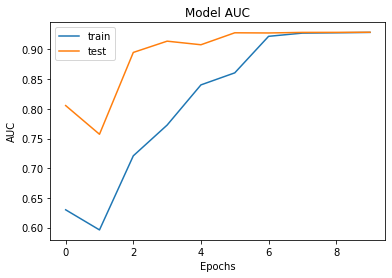

In [35]:
plt.plot(history.history["auc"])
plt.plot(history.history["val_auc"])
plt.title("Model AUC")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend(["train", "test"], loc="upper left")
plt.show()

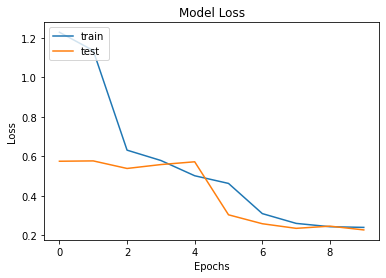

In [36]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["train", "test"], loc="upper left")
plt.show()